In [1]:
import medspacy
from medspacy.visualization import visualize_dep, visualize_ent, MedspaCyVisualizerWidget
from medspacy.ner import TargetRule
from medspacy.context import ConTextItem

# COVID-19 NLP Surveillance
In this notebook, we will look at how NLP can be used for public health in the context of COVID-19 surveillance. We will use the tools in [medspaCy](https://github.com/medspacy/medspacy) which we saw in Weeks 11-12 to process fictional examples of clinical text which indicate whether or not a patient is positive or negative for COVID-19.

# I. Background
This example is based on a pipeline deployed at the US Department of Veterans Affairs. This pipeline processes millions of clinical texts to find patients who have tested positive for COVID-19. Watch the video below for an explanation of the need for NLP in COVID-19 surveillance and a description of this system. You can optionally read the published paper as well: [A Natural Language Processing System for National COVID-19 Surveillance in the US Department of Veterans Affairs](https://www.aclweb.org/anthology/2020.nlpcovid19-acl.10/).

In [2]:
from IPython.display import YouTubeVideo, Image

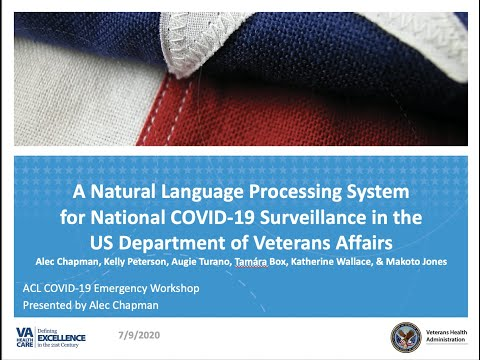

In [3]:
YouTubeVideo("alBnBPtFEAw")

# II. Clinical Texts
In the cell below, we can see a number of short examples of clinical texts mention COVID-19. Before we start building our NLP system, read through the examples and consider the following questions:
- What words/phrases are used to describe COVID-19?
- Which of the texts mention positive cases of COVID-19? What words in the text tell you whether or not they are positive or negative?

In [4]:
texts = [
    "The patient is positive for COVID-19.",
    "The patient's wife tested positive for COVID-19.",
    "Lab Results: SARS-COV-2 Positive",
    "He is worried about getting the Wuhan virus.",
    "Patient presents with concern for novel coronavirus.",
    "The patient was diagnosed with COVID-19.",
    "The patient was dx'd with COVID-19.",
    "Was the patient diagnosed with COVID-19? Y/N",
    "His neighbor recently got coronavirus.",
    "His mother lives in a nursing home where there was an outbreak of COVID",
    "Lab results: SARS-COV-2: (-)",
    "His SARS-COV-2 test came back positive.",
    "His SARS-COV-2 test came back negative.",
    "Neg for COVID.",
    "Negative for COVID.",
    "Pt presents to be tested for COVID-19.",
    "He is worried about getting covid.",
]

# III. Defining our NLP Knowledge Base
In [Weeks 11-12](../week_11_nlp) we learned how to use NLP for extracting information from clinical text. Two of the tasks we learned how to do included:
- Rule-based extraction of medical concepts in text
- Finding modifiers in the text which tell us if a concept is negated, uncertain, experienced by someone else, etc.

We will use these two NLP components to classify texts as **"positive"** or **"negative"** for COVID-19. 

1. Write rules using the `TargetRule` class for extracting mentions of COVID-19
2. Write `ConText` rules which define modifiers telling us whether the patient is positive for COVID-19. 
3. Make a **document classification** based on the entities found in the text. 


We already saw some examples of modifiers in Week 12: **"NEGATED_EXISTENCE"**, **"POSSIBLE_EXISTENCE"**, **"FAMILY"**, **"FUTURE"** and **"HISTORICAL"**. We will also use a category of **"POSITIVE_EXISTENCE"** which says whether the patient is explicitly stated to be positive for COVID-19.

## Examples
Consider these three examples which illustrate why we need to use ConText. All 3 texts mention COVID-19, but only the third one is actually positive.

In the first example, the text states that the patient tested "**positive for**" COVID-19. This is explicitly stated as being **"Positive"**. In the second example, it is explicitly stated as **"Negative"**. However, the final example doesn't give any additional information: we don't know if they're positive or negative, so we won't call that patient positive for COVID-19.

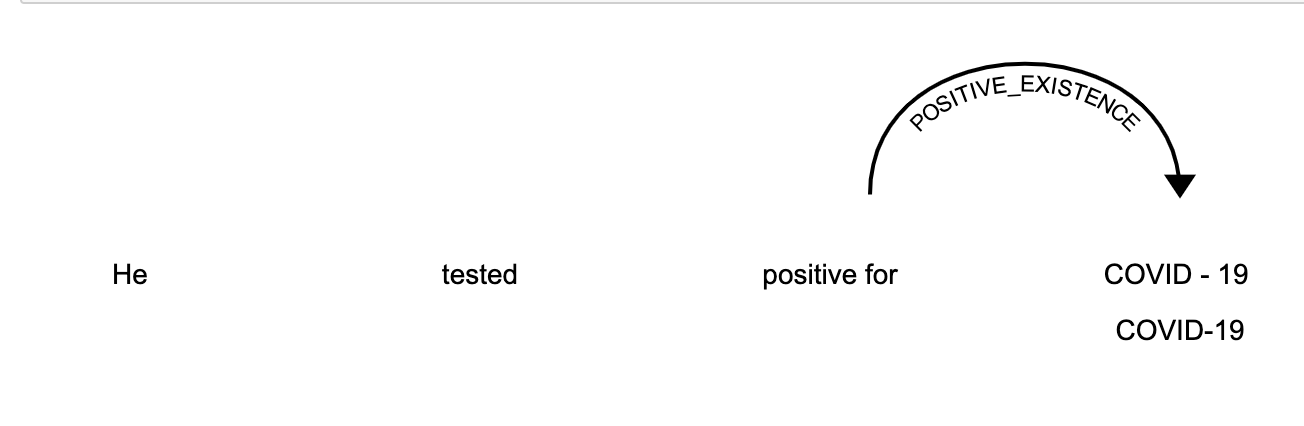

In [5]:
Image("./images/pos_covid-19_text.png", width=700)

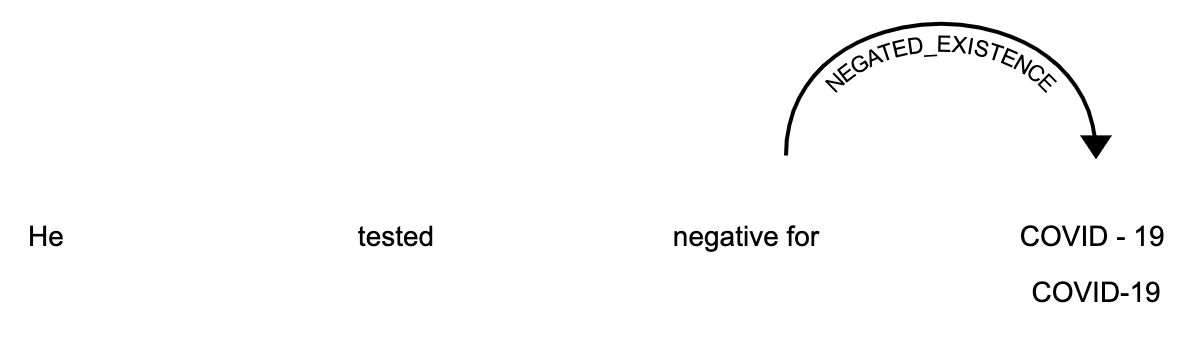

In [6]:
Image("./images/neg_covid-19_text.png", width=700)

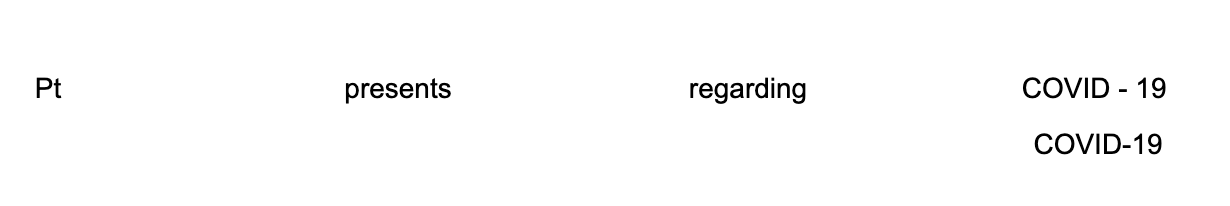

In [7]:
Image("./images/unk_covid-19_text.png", width=700)

## Define NLP Rules
### TODO

In the cells below, define `TargetRules` which define mentions of "COVID-19" and `ConTextItems` which define modifiers such as **"Positive for"** and **"Negative for"**. For a review of how to use these two classes, see the notebooks in [Weeks 11-12](../week_11_nlp).

For `target_rules`, the only category you need to define is **"COVID-19"**.

For `context_rules`, use the following categories for your modifier categories:
- **"POSITIVE_EXISTENCE"**: The text explicitly states the patient has COVID-19
- **"NEGATED_EXISTENCE"**: The text explicitly states the patient **does not** have COVID-19
- **"POSSIBLE_EXISTENCE"**: There is a possibility that the patient has COVID-19
- **"FAMILY"**: Someone other than the patient has COVID-19
- **"FUTURE"**: The text is discussing a hypothetical situation

In [8]:
target_rules = [
    TargetRule("COVID-19", "COVID-19"),
]

In [9]:
context_rules = [
    ConTextItem("Positive for", "POSITIVE_EXISTENCE", rule="FORWARD"),
]

# IV. Build our NLP Model and Process Texts
Now that we have our rules defined, we can load a model using `medspacy` and add our rules to the appropriate components. We'll then call `nlp.pipe(texts)` to create our processed docs.

In [10]:
nlp = medspacy.load(load_rules=False)

In [11]:
nlp.pipe_names

['sentencizer', 'target_matcher', 'context']

In [12]:
target_matcher = nlp.get_pipe("target_matcher")
target_matcher.add(target_rules)

In [13]:
context = nlp.get_pipe("context")
context.add(context_rules)

In [14]:
docs = list(nlp.pipe(texts))

In [15]:
docs

[The patient is positive for COVID-19.,
 The patient's wife tested positive for COVID-19.,
 Lab Results: SARS-COV-2 Positive,
 He is worried about getting the Wuhan virus.,
 Patient presents with concern for novel coronavirus.,
 The patient was diagnosed with COVID-19.,
 The patient was dx'd with COVID-19.,
 Was the patient diagnosed with COVID-19? Y/N,
 His neighbor recently got coronavirus.,
 His mother lives in a nursing home where there was an outbreak of COVID,
 Lab results: SARS-COV-2: (-),
 His SARS-COV-2 test came back positive.,
 His SARS-COV-2 test came back negative.,
 Neg for COVID.,
 Negative for COVID.,
 Pt presents to be tested for COVID-19.,
 He is worried about getting covid.]

## Document Classification
After extracting COVID-19 and analyzing the context, We will use a simple classification schema to decide whether or not a text is positive or negative:
   - If there is at least one mention of COVID-19 which is not negated, uncertain, etc... **and** is modified by **"POSITIVE_EXISTENCE"**, then predict **"Positive"**
   - If there are no mentions of COVID-19, or only mentions which are negated/uncertain or are not positive, then predict **"Negative"**
   
The functions below implement this logic.

In [16]:
def classify_doc(doc):
    """Classify a doc as either 'Positive' or 'Negative' for COVID-19.
    A doc will be called positive if there is at least one mention of 
    COVID-19 which is not negated, uncertain, etc... 
    and is modified by "POSITIVE_EXISTENCE".
    
    Otherwise, the doc will be called 'Negative'
    """
    for ent in doc.ents:
        if ent.label_ != "COVID-19":
            continue
        if not any([ent._.is_negated, ent._.is_historical, 
                    ent._.is_family, ent._.is_uncertain, 
                    ent._.is_hypothetical]):
            if is_modified_by(ent, "POSITIVE_EXISTENCE"):
                return "Positive"
    return "Negative"
        
def is_modified_by(ent, category):
    """Helper function to check whether an entity is 
    modified by a certain category with ConText."""
    for modifier in ent._.modifiers:
        if modifier.category == category:
            return True
    return False

Now we'll use this function to separate our docs into positive and negative docs:

In [17]:
pos_docs = []
neg_docs = []
for doc in docs:
    if classify_doc(doc) == "Positive":
        pos_docs.append(doc)
    if classify_doc(doc) == "Negative":
        neg_docs.append(doc)

# V. Review Output and Fix Mistakes
Now let's review our NLP output and document classifications. Like we've done in previous notebooks, go through the docs using either a widget or manually visualizing each one and look for mistakes. For each doc that you see, ask the following questions:
- Did the NLP extract all the mentions of COVID-19? Did it miss anything? If so, you'll need to add some additional phrases to `target_rules`
- Did the NLP correctly identify modifiers in the text for positive/negative/certainty? If not, add additional rules to `context_rules`
- Was the document correctly classified as positive or negative? If not, why?

Update the rules and then rerun starting at **Section IV** to rebuild your model and reprocess your texts. Iterate until you've correctly classified each of the texts.

In [18]:
pos_docs

[The patient is positive for COVID-19.,
 Lab Results: SARS-COV-2 Positive,
 The patient was diagnosed with COVID-19.,
 The patient was dx'd with COVID-19.,
 His SARS-COV-2 test came back positive.]

In [19]:
w_pos = medspacy.visualization.MedspaCyVisualizerWidget(pos_docs)
# visualize_ent(pos_docs[0])

Box(children=(HBox(children=(RadioButtons(options=('Ent', 'Dep', 'Both'), value='Ent'), Button(description='Pr…

In [20]:
neg_docs

[The patient's wife tested positive for COVID-19.,
 He is worried about getting the Wuhan virus.,
 Patient presents with concern for novel coronavirus.,
 Was the patient diagnosed with COVID-19? Y/N,
 His neighbor recently got coronavirus.,
 His mother lives in a nursing home where there was an outbreak of COVID,
 Lab results: SARS-COV-2: (-),
 His SARS-COV-2 test came back negative.,
 Neg for COVID.,
 Negative for COVID.,
 Pt presents to be tested for COVID-19.,
 He is worried about getting covid.]

In [21]:
w_neg = medspacy.visualization.MedspaCyVisualizerWidget(neg_docs)

Box(children=(HBox(children=(RadioButtons(options=('Ent', 'Dep', 'Both'), value='Ent'), Button(description='Pr…